In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing import image
from keras.models import Sequential
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Conv2D
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import keras
import cv2
import os


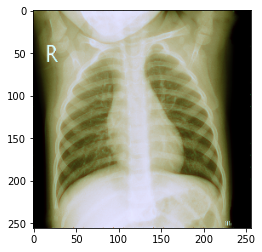

In [2]:
# just show an image
img_try = image.load_img("./training/health/3.png")
plt.imshow(img_try)

In [3]:
# check the size of the image (width, height, channel), channel should be equal to 3 since pseudo color image formation is done
cv2.imread("./training/health/3.png").shape

(256, 256, 3)

In [4]:
# get the training set from train directory, categorial is used since softmax is applied at the last layer, shuffle the training set too
train = ImageDataGenerator()
training_data = train.flow_from_directory("./training/", target_size=(224,224), class_mode="categorical", shuffle=True)

X_train, y_train = training_data.next()

Found 10000 images belonging to 2 classes.


In [6]:
training_data.class_indices

{'covid': 0, 'health': 1}

In [35]:
# same, get the testing set from test directory
test = ImageDataGenerator()
testing_data = test.flow_from_directory("./testing/", target_size=(224,224), class_mode="categorical", shuffle=True)

X_test, y_test = testing_data.next()

Found 495 images belonging to 2 classes.


In [8]:
testing_data.class_indices

{'covid': 0, 'health': 1}

In [9]:
# decay the learning rate every 5 epoch
def lr_time_based_decay(epoch, lr):
    if epoch % 5 == 0:
        return lr*0.8
    return lr

In [13]:
# define cnn model as designed, even it is binary class, softmax with one hot encoding is used (improved performance)
VGG = keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')
VGG.trainable = False

model = keras.Sequential([
  VGG,
  keras.layers.Flatten(),
  keras.layers.Dense(units=256,activation="relu"),
  keras.layers.Dense(units=128,activation="relu"),
  keras.layers.Dense(units=2, activation="softmax")
])

In [14]:
# define some other parameters for cnn model, get the precision & recall (validation set is treated as test set) by using metrics
opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 21,170,626
Trainable params: 6,455,938
Non-trainable params: 14,714,688
_________________________________________________________________


In [15]:
# training begin
hist = model.fit(X_train, y_train, batch_size=4, epochs=20, validation_data=(X_test, y_test),callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)])

# hist = model.fit_generator(steps_per_epoch=4,generator=training_data, validation_data= testing_data,shuffle=True, validation_steps=10,epochs=200,callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)])


Epoch 00001: LearningRateScheduler reducing learning rate to 7.999999797903002e-06.
Epoch 1/20
8/8 [==============================] - 15s 2s/step - loss: 5.4068 - accuracy: 0.5625 - precision_1: 0.5625 - recall_1: 0.5625 - val_loss: 2.1443 - val_accuracy: 0.6875 - val_precision_1: 0.6875 - val_recall_1: 0.6875

Epoch 00002: LearningRateScheduler reducing learning rate to 7.999999979801942e-06.
Epoch 2/20
8/8 [==============================] - 16s 2s/step - loss: 1.1277 - accuracy: 0.6875 - precision_1: 0.6875 - recall_1: 0.6875 - val_loss: 1.1557 - val_accuracy: 0.6875 - val_precision_1: 0.6875 - val_recall_1: 0.6875

Epoch 00003: LearningRateScheduler reducing learning rate to 7.999999979801942e-06.
Epoch 3/20
8/8 [==============================] - 16s 2s/step - loss: 0.0823 - accuracy: 0.9688 - precision_1: 0.9688 - recall_1: 0.9688 - val_loss: 0.8691 - val_accuracy: 0.7812 - val_precision_1: 0.7812 - val_recall_1: 0.7812

Epoch 00004: LearningRateScheduler reducing learning rate to

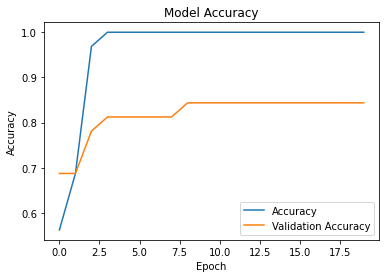

In [16]:
# plot graph
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

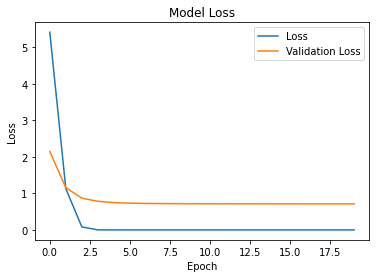

In [17]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

In [18]:
model.save('cnn_vgg16')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: cnn_vgg16\assets


In [27]:
y_pred = model.predict(X_test)
y_pred

array([[1.78133132e-06, 9.99998212e-01],
       [7.34603915e-08, 9.99999881e-01],
       [8.88571143e-04, 9.99111354e-01],
       [2.65949173e-04, 9.99733984e-01],
       [4.40102637e-01, 5.59897363e-01],
       [7.88653961e-06, 9.99992132e-01],
       [7.38263249e-01, 2.61736661e-01],
       [9.62867081e-01, 3.71329300e-02],
       [1.63100840e-08, 1.00000000e+00],
       [9.36890244e-01, 6.31097406e-02],
       [9.81708884e-01, 1.82911269e-02],
       [9.99953628e-01, 4.63288125e-05],
       [3.33978623e-01, 6.66021347e-01],
       [1.04272500e-01, 8.95727515e-01],
       [9.92466748e-01, 7.53322104e-03],
       [8.48125978e-08, 9.99999881e-01],
       [3.69039549e-06, 9.99996305e-01],
       [1.73459528e-03, 9.98265445e-01],
       [1.12069920e-02, 9.88792956e-01],
       [2.87105337e-07, 9.99999762e-01],
       [1.55179258e-02, 9.84482050e-01],
       [9.99997020e-01, 3.03702268e-06],
       [9.99997258e-01, 2.79630331e-06],
       [9.59017500e-03, 9.90409851e-01],
       [1.735535

In [32]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_pred

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1], dtype=int64)